In [61]:
import pandas as pd
import numpy as np
import decoupler as dc
import seaborn as sns
import gseapy as gp
import matplotlib.pyplot as plt
import matplotlib
import json
import scipy as sp
from plot_lib import plot_bubbles, plot_enrich
from plotnine import ggsave

In [62]:
#Okabe- Ito palette
pal = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F5C710", "#0072B2", "#D55E00", "#CC79A7", "#999999"]

# define top and bottom colormaps 
top = plt.get_cmap('Oranges_r', 128) # r means reversed version
bottom = plt.get_cmap('Blues', 128)# combine it all
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))# create a new colormaps with a name of OrangeBlue
orange_blue = matplotlib.colors.ListedColormap(newcolors, name='OrangeBlue')

In [63]:
color_pal = {}
for x in zip(["CollecTri", "M2Kb_K-562", "M2Kb_MCF-7", "M2Kb_HepG2", "M2Kb_GM-12878", "CA_K-562", "CA_MCF-7", "CA_HepG2", "CA_GM-12878"], 
             [pal[7], pal[2], pal[3], pal[4], pal[8], pal[1], pal[0], pal[5], pal[6]]):
    color_pal[x[0]] = matplotlib.colors.to_rgba(x[1])
    
cmap = matplotlib.colors.ListedColormap([pal[7], pal[2], pal[3], pal[4], pal[8], pal[1], pal[0], pal[5], pal[6]])
net_dict = {"CollecTri": 7, 
            "M2Kb_K-562": 2, 
            "M2Kb_MCF-7": 3, 
            "M2Kb_HepG2": 4, 
            "M2Kb_GM-12878": 8,
            "CA_K-562": 1,
            "CA_MCF-7": 0,
            "CA_HepG2": 5,
            "CA_GM-12878": 6}

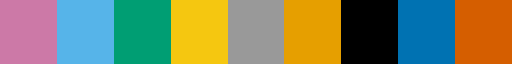

In [64]:
cmap

Network data loading

In [65]:
collectri = dc.get_collectri(organism='human', split_complexes=False)

In [66]:
chip_atlas_k562 = pd.read_table("../data/regulons/ChIP-Atlas_target_genes_K562.tsv", sep="\t")

In [67]:
chip_atlas_k562.head()

,tf,Target_genes
0,ADNP,TRMT2A
1,ADNP,RANBP1
2,ADNP,OSCAR
3,ADNP,NDUFA3
4,ADNP,PSMD9


In [68]:
k562 = pd.read_table("../data/regulons/K562_regulon.tsv", sep="\t")

k562 = k562.loc[k562.is_method_2 & k562.is_atac, ["tf", "gene_symbol"]].drop_duplicates(["tf", "gene_symbol"])
k562 = k562.loc[k562.tf.isin(collectri.source) & k562.tf.isin(chip_atlas_k562.tf)]
k562.shape

(1429281, 2)

In [69]:
chip_atlas_k562 = chip_atlas_k562.loc[chip_atlas_k562.tf.isin(k562.tf)]
chip_atlas_k562.shape

(1086521, 2)

In [70]:
collectri = collectri[collectri.source.isin(k562.tf)]

### Prepare cosmic

In [71]:
COSMIC = dc.get_resource('CancerGeneCensus')

COSMIC.tumour_types_somatic = COSMIC.tumour_types_somatic.str.split(";")

COSMIC = COSMIC.explode("tumour_types_somatic")
cosmic_dict = {}
for typ in COSMIC.tumour_types_somatic.drop_duplicates():
    if COSMIC.loc[COSMIC.tumour_types_somatic == typ].genesymbol.shape[0] > 1:
        cosmic_dict[typ] = COSMIC.loc[COSMIC.tumour_types_somatic == typ].genesymbol.to_list()

# AML integrated dataset

### C6 vs other leukemic cells

In [72]:
data = pd.read_csv("../data/case_study/c6_vs_other_leukemic_cells_aml_dataset.csv", sep=";", index_col=0)
data

,n patients up,n patients down,Mean log2 Fold Change,SD log2 FC,Sum of log p values,n patients significant (consistent sign),Metadata: Takao & Kentsis LRC,Metadata: Velten
Gene,,,,,,,,
AREG,7,0,"2,3179424781",1,44,7,NaN,Other
FOS,7,0,"2,0089384569",1,42,7,NaN,AP1 factors
FTH1,7,0,"1,2502755149",1,60,7,NaN,Erythromyeloid priming
SLC40A1,7,0,"1,2451559941",1,47,7,1.0,Erythromyeloid priming
CD69,6,0,"1,0858648734",1,39,6,NaN,Other
...,...,...,...,...,...,...,...,...
YPEL3,1,1,"0,0845519869",0,15,0,NaN,Other
YWHAZ,1,1,"0,0008226982",0,7,0,NaN,Erythromyeloid priming
ZEB2,2,2,"-0,1924227130",1,26,0,-1.0,Other


In [73]:
de_genes = data.loc[data["n patients significant (consistent sign)"] > 0]["Mean log2 Fold Change"].str.replace(",",'.').astype("float").to_frame()
de_genes.head()
de_genes["leukemic"] = - de_genes["Mean log2 Fold Change"]
#de_genes = de_genes[de_genes["Mean log2 Fold Change"].abs() > 1]

In [74]:
de_genes

,Mean log2 Fold Change,leukemic
Gene,,
AREG,2.317942,-2.317942
FOS,2.008938,-2.008938
FTH1,1.250276,-1.250276
SLC40A1,1.245156,-1.245156
CD69,1.085865,-1.085865
...,...,...
ZSCAN18,0.277256,-0.277256
ZSCAN26,0.920350,-0.920350
ZSWIM6,0.433205,-0.433205


In [75]:
#enr = gp.enrich(de_genes.loc[de_genes["leukemic"].abs() > 1, :].index.to_list(), "DisGeNET")
enr = gp.enrich(de_genes.index.to_list(), "DisGeNET")
enr.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,DisGeNET,"Leukemia, Myelocytic, Acute",446/1703,4.340686e-30,3.762073e-26,0,0,2.015400,136.260247,RB1;CDA;CHIC2;SPI1;TFRC;BACH1;GLS;GJA1;HOXA9;M...
1,DisGeNET,leukemia,491/1941,2.413857e-29,1.046045e-25,0,0,1.931294,127.260209,RB1;CDA;CHIC2;SPI1;RNH1;TFRC;EHMT1;SMC4;GLS;SM...
2,DisGeNET,Acute lymphocytic leukemia,265/907,4.159066e-25,1.201554e-21,0,0,2.286223,128.347040,RB1;IL1RN;SPI1;GFI1;JMJD1C;IKZF1;ACTB;GLS;LGAL...
3,DisGeNET,Precursor Cell Lymphoblastic Leukemia Lymphoma,192/618,1.124858e-21,2.437286e-18,0,0,2.467956,119.045868,RB1;IL1RN;CSF1;IRS1;MPG;GFI1;ATN1;F13A1;SLA;JM...
4,DisGeNET,"Liver Cirrhosis, Experimental",227/801,8.673278e-20,1.503426e-16,0,0,2.171344,95.303432,IFITM1;WIPF1;GMFG;ICAM2;ZDHHC2;GLS;SMC2;LGALS3...
...,...,...,...,...,...,...,...,...,...,...
8662,DisGeNET,Ragged-red muscle fibers,1/42,9.993174e-01,9.996634e-01,0,0,0.128493,0.000088,TYMP
8663,DisGeNET,Rat Adrenal Gland Pheochromocytoma,1/42,9.993174e-01,9.996634e-01,0,0,0.128493,0.000088,BCL2L1
8664,DisGeNET,Retinal Dystrophies,14/178,9.995380e-01,9.997687e-01,0,0,0.448258,0.000207,PEX16;HGSNAT;PRPS1;GRN;SUCNR1;TRAF3IP1;PRPF8;T...
8665,DisGeNET,Syndactyly,4/85,9.996806e-01,9.997960e-01,0,0,0.259783,0.000083,GJA1;NOG;LMNA;ZSWIM6


In [76]:
de_genes.drop("Mean log2 Fold Change", axis=1, inplace=True)

In [77]:
de_genes = de_genes.T

In [78]:
dc.check_corr(k562, mat=de_genes, source="tf", target="gene_symbol", weight=None).sort_values("corr")

,source1,source2,corr
13690,GTF2B,RBFOX2,-0.1391
16111,BRCA1,BRD4,-0.1136
16370,BRCA1,MYC,-0.1114
17082,NONO,RBFOX2,-0.1043
17758,BCLAF1,RBFOX2,-0.0980
...,...,...,...
4,E2F4,HCFC1,0.6583
3,HDAC1,MYC,0.6663
2,MYC,TBP,0.6766
1,CREM,JUND,0.6846


In [79]:
dc.check_corr(collectri, mat=de_genes, weight=None).sort_values("corr")

,source1,source2,corr
3726,MYC,SREBF1,-0.0648
4163,MYC,NCOR1,-0.0537
4354,MYC,TEAD1,-0.0493
4364,E2F6,SP1,-0.0491
4469,ESRRA,TP53,-0.0459
...,...,...,...
4,FOS,JUN,0.4750
3,CTNNB1,TCF7L2,0.5005
2,NFYA,NFYB,0.5345
1,SMAD2,SMAD3,0.5476


In [80]:
aml_disreg_enrich = pd.DataFrame()
aml_omim_enrich = pd.DataFrame()
aml_cosmic_enrich = pd.DataFrame()
megaheat = pd.DataFrame()

K562

In [81]:
tf_acts_k562, tf_pvals_k562= dc.run_ulm(de_genes, k562, source='tf', target='gene_symbol', weight=None)

#tf_pvals.loc["leukemic"] = fdrcorrection(tf_pvals.T["leukemic"])[1]

In [82]:
mask = tf_pvals_k562 < 0.01
active_tfs_k562 = tf_acts_k562.loc["leukemic", pd.DataFrame(tf_acts_k562 * mask).sum(axis=0) != 0].index.to_list()

In [83]:
tf_acts_k562.index = ["score"]
tf_pvals_k562.index = ["p_value"]
out_k562 = pd.merge(left=tf_acts_k562.T, right=tf_pvals_k562.T, left_index=True, right_index=True)
out_k562.to_csv("../data/3-tf_activity/aml_k562_activity_m2kb.tsv", sep="\t", index=False)

In [84]:
enr = gp.enrich(active_tfs_k562, "OMIM_Expanded")
enr.results["Network"] = "M2Kb_K-562"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_omim_enrich_m2kb_k562_hsc.tsv", sep="\t", index=False)
aml_omim_enrich = pd.concat([aml_omim_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [85]:
enr = gp.enrich(active_tfs_k562, "DisGeNET")
enr.results["Network"] = "M2Kb_K-562"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_disgenet_enrich_m2kb_k562_hsc.tsv", sep="\t", index=False)
aml_disreg_enrich = pd.concat([aml_disreg_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [86]:
try:
    enr = gp.enrich(gene_list=active_tfs_k562, gene_sets=cosmic_dict, background=None)
    enr.results["Network"] = "M2Kb_K-562"
    enr.results.to_csv("../data/3-tf_disease_enrichment/aml_cosmic_enrich_m2kb_k562_hsc.tsv", sep="\t", index=False)
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except ValueError:
    enr.results["Network"] = "M2Kb_K-562"
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, pd.DataFrame()], axis=0)

In [87]:
heat = pd.concat([tf_acts_k562.rename({"leukemic": "score"}), tf_pvals_k562.rename({"leukemic": "p_value"})], axis=0).T
#heat = heat.reindex(heat.abs().sort_values("leukemic", ascending=False).index).head(5)
heat["Network"] = "M2Kb_K-562"
#heat["TFs"] = heat.index
megaheat = pd.concat([megaheat, heat], axis =0)
megaheat

,score,p_value,Network
ADNP,0.034834,0.972214,M2Kb_K-562
ARHGAP35,0.111232,0.911439,M2Kb_K-562
ARID1B,-0.887388,0.374937,M2Kb_K-562
ARID3A,-1.116211,0.264416,M2Kb_K-562
ARID3B,-1.265408,0.205818,M2Kb_K-562
...,...,...,...
ZNF436,0.420378,0.674238,M2Kb_K-562
ZNF444,-0.321460,0.747883,M2Kb_K-562
ZNF76,0.374339,0.708177,M2Kb_K-562
ZNF77,-1.964353,0.049576,M2Kb_K-562


CollecTri

In [88]:
tf_acts_ctri, tf_pvals_ctri = dc.run_ulm(de_genes, collectri, weight=None)
#tf_pvals_ctri.loc["leukemic"] = fdrcorrection(tf_pvals_ctri.T["leukemic"])[1]

In [89]:
mask_ctri = tf_pvals_ctri < 0.01
active_tfs_ctri = tf_acts_ctri.loc["leukemic", pd.DataFrame(tf_acts_ctri * mask_ctri).sum(axis=0) != 0].index.to_list()
tf_acts_ctri.loc["leukemic", pd.DataFrame(tf_acts_ctri * mask_ctri).sum(axis=0) != 0].sort_values()

CREB1   -3.125075
NFE2    -2.893968
NFIC    -2.653232
KLF1    -2.627798
ELF1     2.671553
TCF7     2.791151
LEF1     2.884972
RFX5     2.920896
EZH2     2.955058
HEY1     3.074861
SP1      3.195663
SPI1     3.734423
Name: leukemic, dtype: float32

In [90]:
tf_acts_ctri.index = ["score"]
tf_pvals_ctri.index = ["p_value"]
out_ctri = pd.merge(left=tf_acts_ctri.T, right=tf_pvals_ctri.T, left_index=True, right_index=True)
out_ctri.to_csv("../data/3-tf_activity/aml_k562_activity_collectri.tsv", sep="\t", index=False)

In [91]:
enr = gp.enrich(active_tfs_ctri, "OMIM_Expanded")
enr.results["Network"] = "CollecTri"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_omim_enrich_collectri_hsc.tsv", sep="\t", index=False)
aml_omim_enrich = pd.concat([aml_omim_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [92]:
enr = gp.enrich(active_tfs_ctri, "DisGeNET")
enr.results["Network"] = "CollecTri"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_disgenet_enrich_collectri_hsc.tsv", sep="\t", index=False)
aml_disreg_enrich = pd.concat([aml_disreg_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [93]:
try:
    enr = gp.enrich(gene_list=active_tfs_ctri, gene_sets=cosmic_dict, background=None)
    enr.results["Network"] = "CollecTri"
    enr.results.to_csv("../data/3-tf_disease_enrichment/aml_cosmic_enrich_collectri_hsc.tsv", sep="\t", index=False)
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except ValueError:
    enr.results["Network"] = "CollecTri"
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, pd.DataFrame()], axis=0)

In [94]:
heat = pd.concat([tf_acts_ctri.rename({"leukemic": "score"}), tf_pvals_ctri.rename({"leukemic": "p_value"})], axis=0).T
#heat = heat.reindex(heat.abs().sort_values("leukemic", ascending=False).index).head(5)
heat["Network"] = "CollecTri"
#heat["TFs"] = heat.index
megaheat = pd.concat([megaheat, heat], axis =0)
megaheat

,score,p_value,Network
ADNP,0.034834,0.972214,M2Kb_K-562
ARHGAP35,0.111232,0.911439,M2Kb_K-562
ARID1B,-0.887388,0.374937,M2Kb_K-562
ARID3A,-1.116211,0.264416,M2Kb_K-562
ARID3B,-1.265408,0.205818,M2Kb_K-562
...,...,...,...
YBX3,-0.825308,0.409259,CollecTri
YY1,1.131990,0.257724,CollecTri
ZBED1,-0.299977,0.764214,CollecTri
ZBTB7A,-0.463390,0.643116,CollecTri


chip_atlas_k562

In [95]:
tf_acts_chip_atlas_k562, tf_pvals_chip_atlas_k562 = dc.run_ulm(de_genes, chip_atlas_k562.drop_duplicates(), source='tf', target='Target_genes', weight=None)

#tf_pvals.loc["leukemic"] = fdrcorrection(tf_pvals.T["leukemic"])[1]

In [96]:
tf_pvals_chip_atlas_k562

,ADNP,ARHGAP35,ARID1B,ARID3A,ARID3B,ARNT,ASH1L,ATF1,ATF2,ATF3,...,ZNF274,ZNF281,ZNF316,ZNF384,ZNF395,ZNF436,ZNF444,ZNF76,ZNF77,ZNF79
leukemic,0.474575,0.917271,0.525063,0.127674,0.615401,0.276648,0.995348,0.035705,0.002523,0.1869,...,0.344477,0.145598,0.456509,0.418333,0.110102,0.215864,0.842052,0.702109,0.719365,0.11751


In [97]:
mask_chip_atlas_k562 = tf_pvals_chip_atlas_k562 < 0.01

active_tfs_chip_atlas_k562 = tf_acts_chip_atlas_k562.loc["leukemic", pd.DataFrame(tf_acts_chip_atlas_k562 * mask_chip_atlas_k562).sum(axis=0) != 0].index.to_list()

In [99]:
tf_acts_chip_atlas_k562.index = ["score"]
tf_pvals_chip_atlas_k562.index = ["p_value"]
out_chip_atlas = pd.merge(left=tf_acts_chip_atlas_k562.T, right=tf_pvals_chip_atlas_k562.T, left_index=True, right_index=True)
out_chip_atlas.to_csv("../data/3-tf_activity/aml_k562_activity_ca_k562.tsv", sep="\t", index=False)

In [100]:
active_tfs_chip_atlas_k562

['ATF2',
 'CREM',
 'E2F1',
 'E2F4',
 'FOXJ2',
 'FOXK2',
 'FOXM1',
 'GABPA',
 'HEY1',
 'IRF1',
 'JUN',
 'LDB1',
 'MBD2',
 'PBX2',
 'RBFOX2',
 'RREB1',
 'SMAD5',
 'TAF1',
 'TBL1XR1',
 'TBP',
 'TFDP1',
 'UBTF',
 'USF1',
 'YY1',
 'ZBTB12',
 'ZNF148']

In [101]:
enr = gp.enrich(active_tfs_chip_atlas_k562, "OMIM_Expanded")
enr.results["Network"] = "CA_K-562"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_omim_enrich_ca_k562_hsc.tsv", sep="\t", index=False)
aml_omim_enrich = pd.concat([aml_omim_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [102]:
enr = gp.enrich(active_tfs_chip_atlas_k562, "DisGeNET")
enr.results["Network"] = "CA_K-562"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_disgenet_enrich_ca_k562_hsc.tsv", sep="\t", index=False)
aml_disreg_enrich = pd.concat([aml_disreg_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [103]:
try:
    enr = gp.enrich(gene_list=active_tfs_chip_atlas_k562, gene_sets=cosmic_dict, background=None)
    enr.results["Network"] = "CA_K-562"
    enr.results.to_csv("../data/3-tf_disease_enrichment/aml_cosmic_enrich_ca_k562_hsc.tsv", sep="\t", index=False)
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except ValueError:
    enr.results["Network"] = "CA_K-562"
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, pd.DataFrame()], axis=0)

In [104]:
heat = pd.concat([tf_acts_chip_atlas_k562.rename({"leukemic": "score"}), tf_pvals_chip_atlas_k562.rename({"leukemic": "p_value"})], axis=0).T
#heat = heat.reindex(heat.abs().sort_values("leukemic", ascending=False).index).head(5)
heat["Network"] = "CA_K-562"
#heat["TFs"] = heat.index
megaheat = pd.concat([megaheat, heat], axis =0)
megaheat

,score,p_value,Network
ADNP,0.034834,0.972214,M2Kb_K-562
ARHGAP35,0.111232,0.911439,M2Kb_K-562
ARID1B,-0.887388,0.374937,M2Kb_K-562
ARID3A,-1.116211,0.264416,M2Kb_K-562
ARID3B,-1.265408,0.205818,M2Kb_K-562
...,...,...,...
ZNF436,1.237847,0.215864,CA_K-562
ZNF444,0.199285,0.842052,CA_K-562
ZNF76,-0.382510,0.702109,CA_K-562
ZNF77,-0.359340,0.719365,CA_K-562


Plotting results

In [105]:
net_dict = {"CollecTri": 7, 
            "M2Kb_K-562": 2, 
            "M2Kb_MCF-7": 3, 
            "M2Kb_HepG2": 4, 
            "M2Kb_GM-12878": 8,
            "CA_K-562": 1,
            "CA_MCF-7": 0,
            "CA_HepG2": 5,
            "CA_GM-12878": 6}
okabe = [pal[1], pal[7], pal[2]]

In [106]:
aml_omim_enrich["-log10(Adj. P-value)"] = - np.log10(aml_omim_enrich["Adjusted P-value"])
aml_omim_enrich = aml_omim_enrich.loc[aml_omim_enrich["Adjusted P-value"] < 0.05]
aml_omim_enrich.describe()

,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,-log10(Adj. P-value)
count,1.000000,1.000000,1.0,1.0,1.000000,1.00000,1.000000
mean,0.000119,0.021608,0.0,0.0,36.672604,331.47308,1.665391
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000119,0.021608,0.0,0.0,36.672604,331.47308,1.665391
25%,0.000119,0.021608,0.0,0.0,36.672604,331.47308,1.665391
50%,0.000119,0.021608,0.0,0.0,36.672604,331.47308,1.665391
75%,0.000119,0.021608,0.0,0.0,36.672604,331.47308,1.665391
max,0.000119,0.021608,0.0,0.0,36.672604,331.47308,1.665391


/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 30.000000000000004 x 150.0 mm image.
/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/3-tf_disease_enrichment/aml_go_enrich_omim_hsc_new_k562.svg


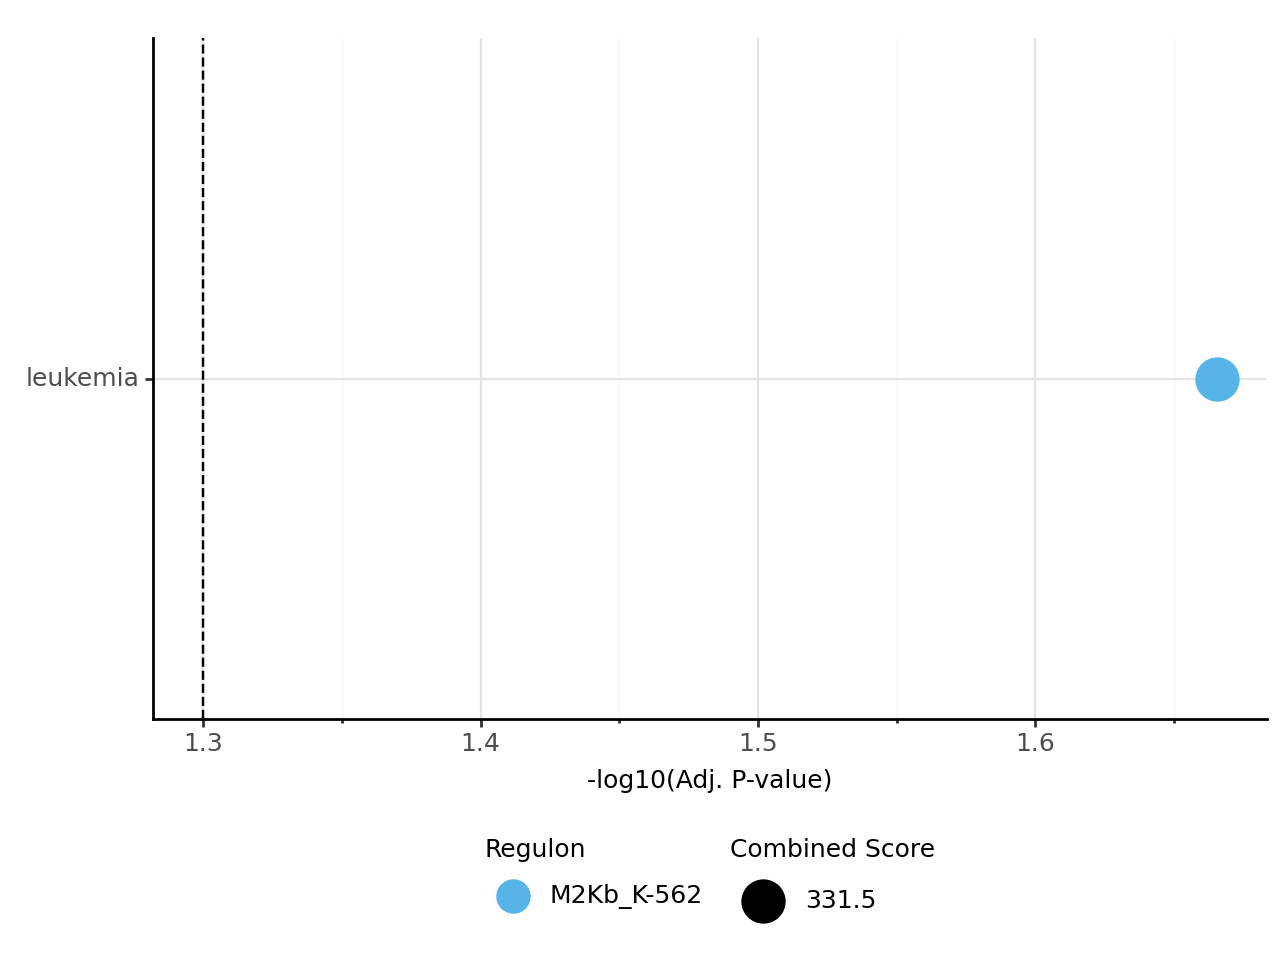

<Figure Size: (640 x 480)>

In [107]:
p = plot_enrich(aml_omim_enrich, okabe[-1])
ggsave(p, "../plots/3-tf_disease_enrichment/aml_go_enrich_omim_hsc_new_k562.svg",  width = 30, height = 150, units = "mm", dpi=720)
p

In [108]:
aml_disreg_enrich["-log10(Adj. P-value)"] = - np.log10(aml_disreg_enrich["Adjusted P-value"])
aml_disreg_enrich = aml_disreg_enrich.loc[aml_disreg_enrich["Adjusted P-value"] < 0.05]
aml_disreg_enrich.describe()

,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,-log10(Adj. P-value)
count,1.500000e+01,1.500000e+01,15.0,15.0,15.000000,15.000000,15.000000
mean,4.689227e-06,9.771680e-04,0.0,0.0,79.396334,1135.601153,4.842195
std,8.215759e-06,1.444873e-03,0.0,0.0,201.204493,2405.857623,2.102093
min,6.371858e-13,9.532300e-10,0.0,0.0,8.854893,142.991205,2.482239
25%,4.311467e-10,1.348427e-07,0.0,0.0,11.074990,185.865692,2.636899
50%,9.525772e-08,2.687663e-05,0.0,0.0,17.056007,246.239524,4.570625
75%,4.801957e-06,2.325786e-03,0.0,0.0,31.295297,588.335385,6.870173
max,2.175879e-05,3.294281e-03,0.0,0.0,799.320000,9496.988892,9.020802


/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 30.000000000000004 x 150.0 mm image.
/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/3-tf_disease_enrichment/aml_go_enrich_disreg_hsc_new_k562.svg


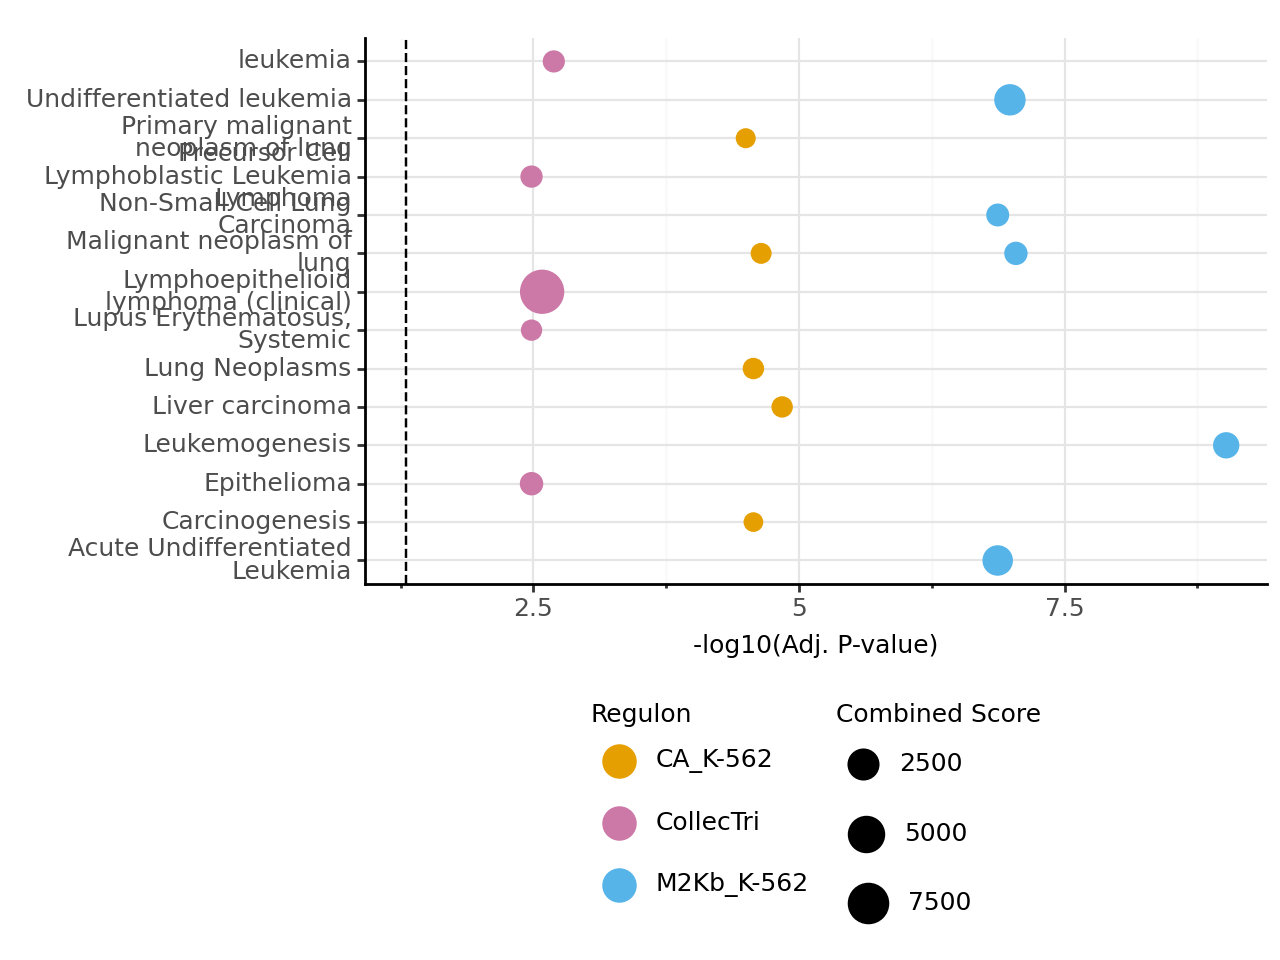

<Figure Size: (640 x 480)>

In [109]:
p = plot_enrich(aml_disreg_enrich, palette=okabe)
ggsave(p, "../plots/3-tf_disease_enrichment/aml_go_enrich_disreg_hsc_new_k562.svg", width = 30, height = 150, units = "mm", dpi=720)
p

In [110]:
aml_cosmic_enrich["-log10(Adj. P-value)"] = - np.log10(aml_cosmic_enrich["Adjusted P-value"])
aml_cosmic_enrich = aml_cosmic_enrich.loc[aml_cosmic_enrich["Adjusted P-value"] < 0.05]
aml_cosmic_enrich.describe()

,P-value,Adjusted P-value,Odds Ratio,Combined Score,-log10(Adj. P-value)
count,9.000000,9.000000,9.000000,9.000000,9.000000
mean,0.015263,0.032433,91.894603,428.900204,1.590921
std,0.006525,0.015025,27.453481,208.344822,0.409398
min,0.000225,0.002472,68.781818,272.922993,1.370731
25%,0.014195,0.018912,68.781818,272.922993,1.380837
50%,0.018912,0.041607,96.384615,382.449583,1.380837
75%,0.018912,0.041607,99.920635,459.157776,1.723260
max,0.018912,0.042586,151.320000,839.396021,2.606953


/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 30.000000000000004 x 150.0 mm image.
/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/3-tf_disease_enrichment/aml_go_enrich_cosmic_hsc_new_k562.svg


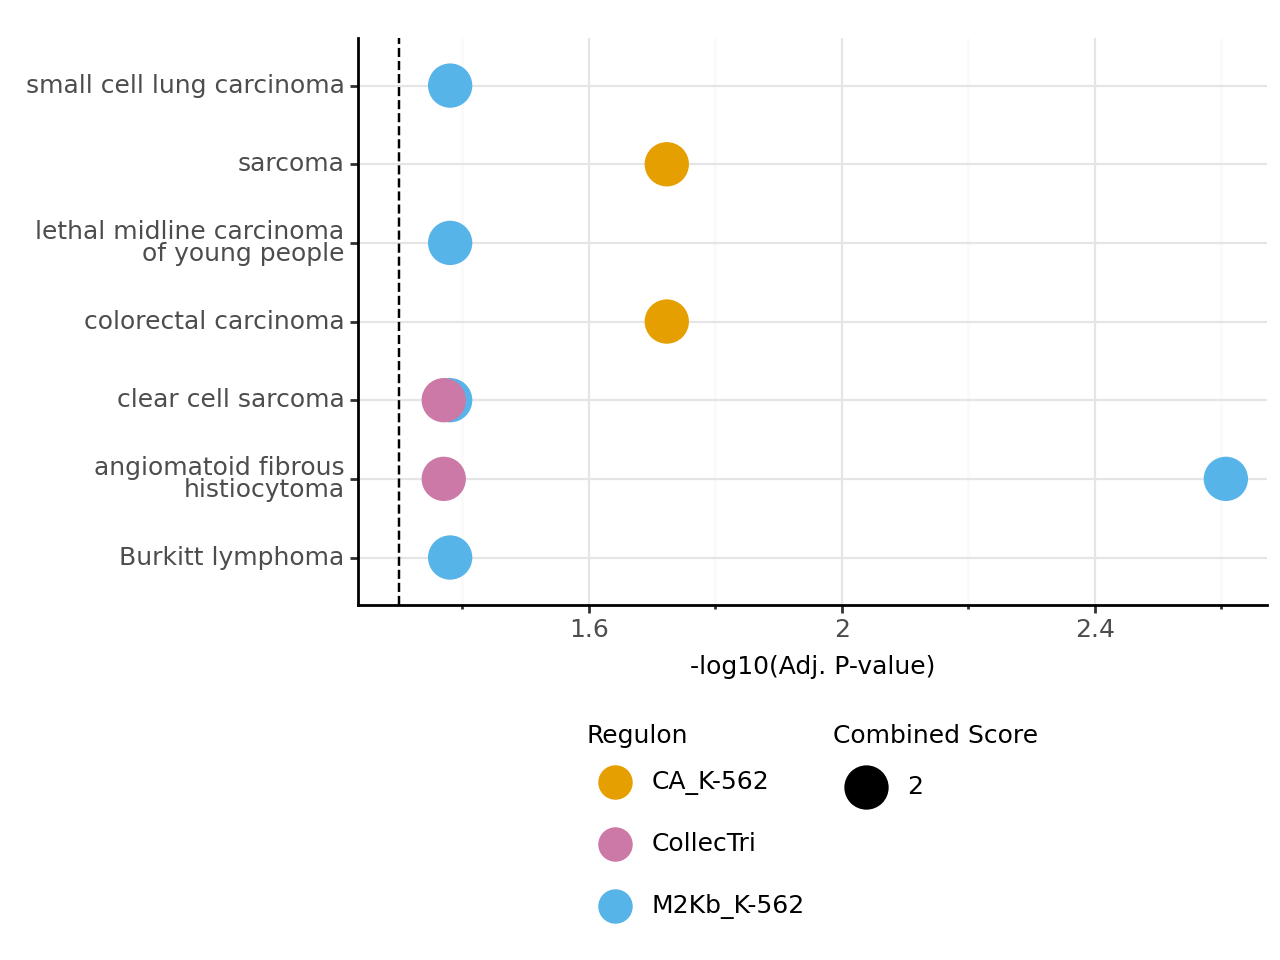

<Figure Size: (640 x 480)>

In [111]:
p = plot_enrich(aml_cosmic_enrich, okabe, size=2)
ggsave(p, "../plots/3-tf_disease_enrichment/aml_go_enrich_cosmic_hsc_new_k562.svg",  width = 30, height = 150, units = "mm", dpi=720)
p

In [112]:
aml_cosmic_enrich = aml_cosmic_enrich.loc[aml_cosmic_enrich["Adjusted P-value"] < 0.05]
aml_cosmic_enrich.describe()

,P-value,Adjusted P-value,Odds Ratio,Combined Score,-log10(Adj. P-value)
count,9.000000,9.000000,9.000000,9.000000,9.000000
mean,0.015263,0.032433,91.894603,428.900204,1.590921
std,0.006525,0.015025,27.453481,208.344822,0.409398
min,0.000225,0.002472,68.781818,272.922993,1.370731
25%,0.014195,0.018912,68.781818,272.922993,1.380837
50%,0.018912,0.041607,96.384615,382.449583,1.380837
75%,0.018912,0.041607,99.920635,459.157776,1.723260
max,0.018912,0.042586,151.320000,839.396021,2.606953


In [113]:
megaheat.describe()

,score,p_value
count,629.000000,629.000000
mean,-0.796356,0.351268
std,1.311740,0.309156
min,-3.768019,0.000168
25%,-1.768095,0.063336
50%,-0.850778,0.266709
75%,0.155112,0.615401
max,3.734423,0.995348


In [114]:
megaheat.to_csv("../data/3-tf_activity/aml_activity_estimates_hsc.tsv", sep="\t", index=False)

In [115]:
megaheat = megaheat[megaheat.p_value < 0.01].sort_values("score")
megaheat["TF"] = megaheat.index
megaheat["log_p"] = - np.log10(megaheat.p_value).round(1)
#megaheat["log_p"] = megaheat["log_p"].astype("str")

In [116]:
print(megaheat[megaheat.Network == "M2Kb_K-562"].sort_values("score").to_string())

           score   p_value     Network      TF  log_p
CREB1  -3.677945  0.000239  M2Kb_K-562   CREB1    3.6
CC2D1A -3.607703  0.000314  M2Kb_K-562  CC2D1A    3.5
HDAC1  -3.560007  0.000376  M2Kb_K-562   HDAC1    3.4
MNT    -3.516632  0.000443  M2Kb_K-562     MNT    3.4
NFATC3 -3.417837  0.000639  M2Kb_K-562  NFATC3    3.2
SAP30  -3.151582  0.001639  M2Kb_K-562   SAP30    2.8
FOXM1  -3.050026  0.002307  M2Kb_K-562   FOXM1    2.6
REST   -3.043476  0.002358  M2Kb_K-562    REST    2.6
BRD4   -2.955158  0.003148  M2Kb_K-562    BRD4    2.5
IRF1   -2.944502  0.003258  M2Kb_K-562    IRF1    2.5
GATA2  -2.886390  0.003923  M2Kb_K-562   GATA2    2.4
E2F1   -2.875396  0.004062  M2Kb_K-562    E2F1    2.4
PHF8   -2.822859  0.004789  M2Kb_K-562    PHF8    2.3
SIN3A  -2.814793  0.004911  M2Kb_K-562   SIN3A    2.3
MYC    -2.773694  0.005575  M2Kb_K-562     MYC    2.3
ATF1   -2.762491  0.005769  M2Kb_K-562    ATF1    2.2
PML    -2.756639  0.005873  M2Kb_K-562     PML    2.2
TBP    -2.723071  0.006503  

In [117]:
print(megaheat[megaheat.Network == "CollecTri"].sort_values("score").to_string())

          score   p_value    Network     TF  log_p
CREB1 -3.125075  0.001794  CollecTri  CREB1    2.7
NFE2  -2.893968  0.003830  CollecTri   NFE2    2.4
NFIC  -2.653232  0.008012  CollecTri   NFIC    2.1
KLF1  -2.627798  0.008635  CollecTri   KLF1    2.1
ELF1   2.671553  0.007589  CollecTri   ELF1    2.1
TCF7   2.791151  0.005283  CollecTri   TCF7    2.3
LEF1   2.884972  0.003941  CollecTri   LEF1    2.4
RFX5   2.920896  0.003515  CollecTri   RFX5    2.5
EZH2   2.955058  0.003149  CollecTri   EZH2    2.5
HEY1   3.074861  0.002124  CollecTri   HEY1    2.7
SP1    3.195663  0.001409  CollecTri    SP1    2.9
SPI1   3.734423  0.000191  CollecTri   SPI1    3.7


In [118]:
megaheat

,score,p_value,Network,TF,log_p
UBTF,-3.768019,0.000168,CA_K-562,UBTF,3.8
CREB1,-3.677945,0.000239,M2Kb_K-562,CREB1,3.6
CC2D1A,-3.607703,0.000314,M2Kb_K-562,CC2D1A,3.5
HDAC1,-3.560007,0.000376,M2Kb_K-562,HDAC1,3.4
MNT,-3.516632,0.000443,M2Kb_K-562,MNT,3.4
...,...,...,...,...,...
RFX5,2.920896,0.003515,CollecTri,RFX5,2.5
EZH2,2.955058,0.003149,CollecTri,EZH2,2.5
HEY1,3.074861,0.002124,CollecTri,HEY1,2.7
SP1,3.195663,0.001409,CollecTri,SP1,2.9


/crex/proj/lappalainen_lab1/users/marii/chip_seq_ann/case_studies/plot_lib.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
/crex/proj/lappalainen_lab1/users/marii/chip_seq_ann/case_studies/plot_lib.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator


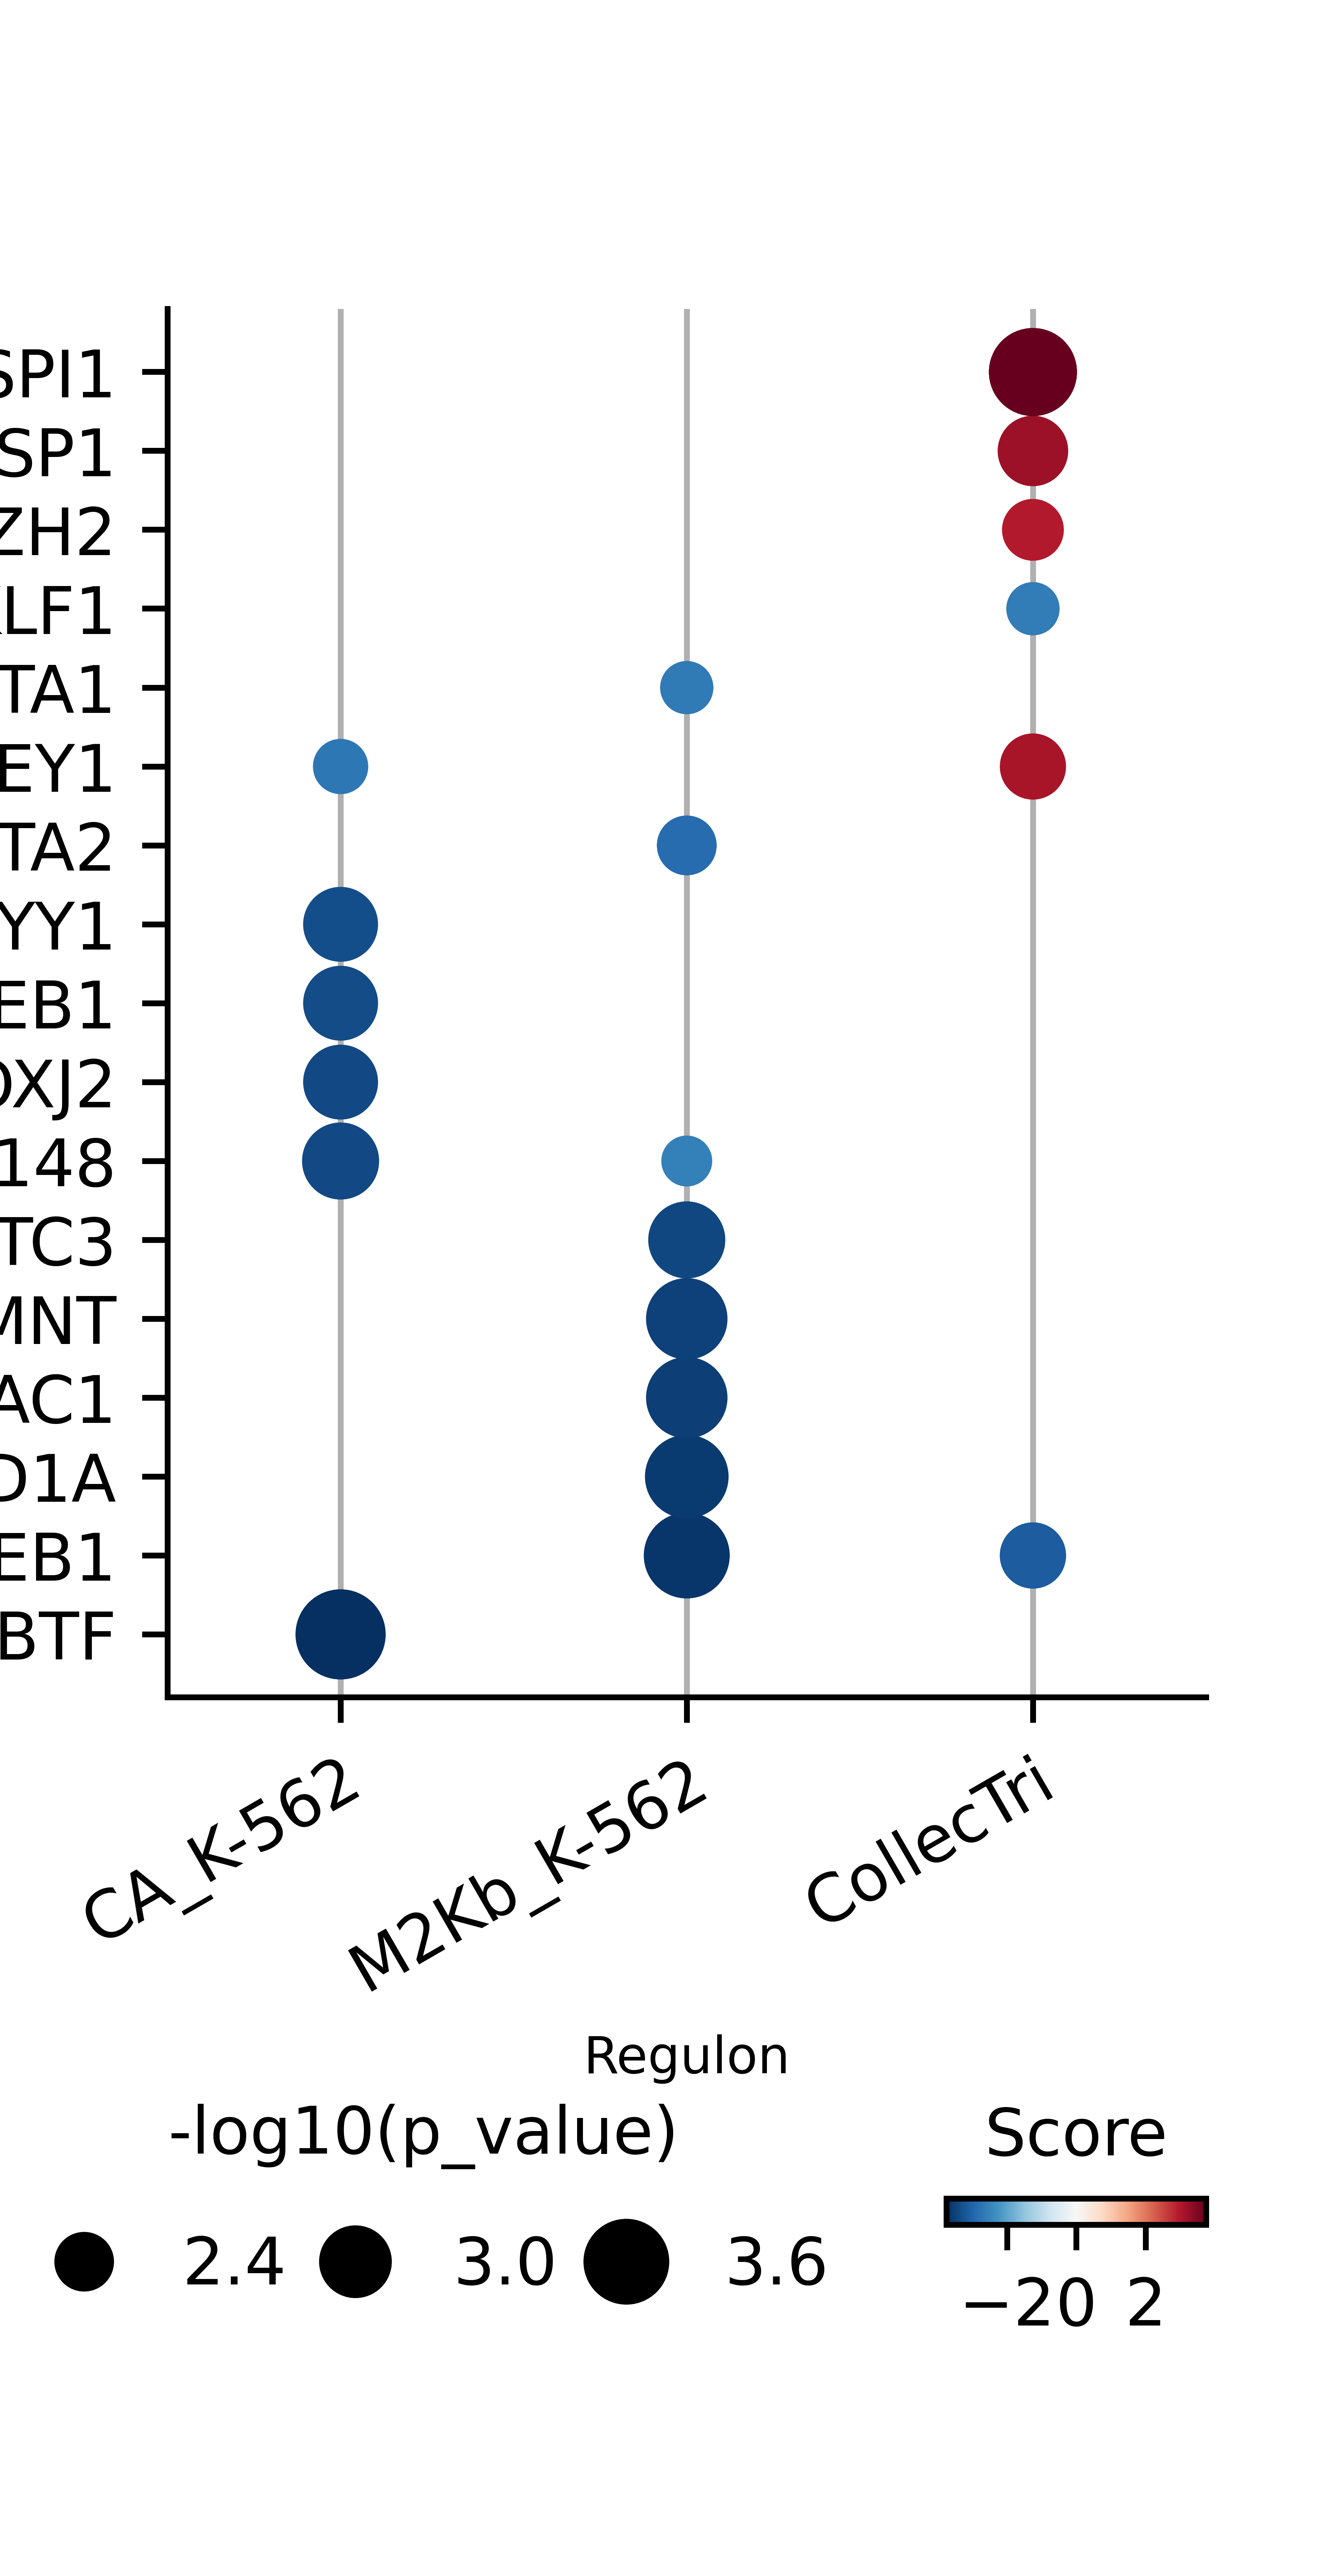

In [119]:
plt.close()
out = pd.DataFrame()
interesting_tf = ["GATA1", "GATA2", "KLF1", "SPI1"]
for net in ["CollecTri", "M2Kb_K-562", "CA_K-562"]:
    mask = megaheat[megaheat.Network == net].score.abs().sort_values(ascending=False).head(5).index
    out = pd.concat([out, megaheat.loc[megaheat.TF.isin(mask) | megaheat.TF.isin(interesting_tf), :]])
plot_bubbles(out, scale=0.5)
plt.savefig("../plots/3-tf_activity/aml_activity_clustermap_hsc_k562.svg", dpi=720, format="svg")
plt.show()

In [120]:
print(", ".join(megaheat[megaheat.Network == "M2Kb_GM-12878"].index.to_list()))

In [121]:
print(", ".join(megaheat[megaheat.Network == "CollecTri"].index.to_list()))

CREB1, NFE2, NFIC, KLF1, ELF1, TCF7, LEF1, RFX5, EZH2, HEY1, SP1, SPI1


In [122]:
enr = gp.enrich(megaheat[megaheat.Network == "CollecTri"].index.to_list(), "KEGG_2021_Human")
enr.results.head(10)
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_kegg_enrich_collectri_hsc.tsv", sep="\t", index=False)

In [123]:
enr = gp.enrich(megaheat[megaheat.Network == "M2Kb_K-562"].index.to_list(), "KEGG_2021_Human")
enr.results.head(10)
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_kegg_enrich_m2kb_k562_hsc.tsv", sep="\t", index=False)